<a href="https://colab.research.google.com/github/Riturao/fyp/blob/master/depression_detect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
#import ost as mi
import re
import numpy as np
import pandas as pd
#from chart_studio import plotly as py
#import plotly.figure_factory as ff
from scipy import stats

import gensim
import json


import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

import itertools

import keras

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Input, Activation, GlobalAveragePooling1D, Flatten, Concatenate, Conv1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import concatenate
from keras.optimizers import SGD, RMSprop, Adagrad, Adam
from keras.preprocessing.text import one_hot, text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

import fnmatch

import warnings

import string
from pathlib import Path
from random import shuffle
from ast import literal_eval

warnings.filterwarnings('ignore')



Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [0]:
wordnet_lemmatizer = WordNetLemmatizer()

In [0]:
WINDOWS_SIZE = 10
labels=['none','mild','moderate','moderately severe', 'severe']
num_classes = len(labels)

In [110]:
def plot_acc(history, title="Model Accuracy"):
    #plt.plot(history.history['accuracy'])
    #plt.plot(history.history['val_accuracy'])

    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Acc')
    
    #plt.title(title)
    #plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1", name2="Red 2", title="Graph title"):
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['acc'], color="green")
    plt.plot(history1.history['val_acc'], 'r--', color="green")
    plt.plot(history2.history['acc'], color="blue")
    plt.plot(history2.history['val_acc'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

def plot_compare_multiple_metrics(history_array, names, colors, title="Graph title", metric='acc'):  
    legend = []
    for i in range(0, len(history_array)):
        plt.plot(history_array[i].history[metric], color=colors[i])
        plt.plot(history_array[i].history['val_' + metric], 'r--', color=colors[i])
        legend.append('Train ' + names[i])
        legend.append('Val ' + names[i])
    
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')   
    plt.axis
    plt.legend(legend, 
               loc='lower right')
    plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 65


In [0]:
def transcripts_to_dataframe(directory):
    rows_list = []
        
    filenames = os.listdir(directory)
    
    if ".DS_Store" in filenames:
        filenames.remove(".DS_Store")
        
    for filename in filenames:
        
        transcript_path = os.path.join(directory, filename)
        transcript = pd.read_csv(transcript_path , sep='\t')
        #print(transcript)
        m = re.search("(\d{3})_TRANSCRIPT.csv", filename)
        if m:
            print(filename)
            person_id = m.group(1)
            #print(person_id)
            p = {}
            question = ""
            answer = ""
            lines = len(transcript)
            #print(lines)
            for i in range(0, lines):
                #print("entered")
                row = transcript.iloc[i]
                #print(row)
                if (row["speaker"] == "Ellie") or (i == lines - 1):
                    p["personId"] = person_id
                    #print(p)
                    if "(" in str(question):
                        question = question[question.index("(") + 1:question.index(")")]
                    p["question"] = question
                    p["answer"] = answer
                    #print(answer)
                    #print(p)
                    if question != "":
                        rows_list.append(p)
                        #print(rows_list())
                    p = {}
                    answer = ""
                    question = row["value"]
                else:
                    answer = str(answer) + " " + str(row["value"])
                    #print(1)
                #print(answer)

    all_participants = pd.DataFrame(rows_list, columns=['personId', 'question', 'answer'])
    #all_participants = pd.DataFrame(*p, columns=['personId', 'question', 'answer'])
    all_participants.to_csv(directory + 'all/all.csv', sep=',')
    print("File was created")
    return all_participants

In [0]:
from google.colab import files

uploaded = files.upload()

In [0]:


for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
#data_path = r"C:/Users/Admin/Desktop/transcripts/"
#transcripts_to_dataframe(data_path) 
all_participants = pd.read_csv('all.csv', sep=',')
#all_participants= pd.read_csv(data_path + '*_TRANSCRIPT.csv', sep=',')
#all_participants = pd.concat([pd.read_csv(f) for f in glob.glob('*_TRANSCRIPT.csv')], ignore_index = True)#

In [0]:
all_participants.tail() 

,Unnamed: 0,personId,question,answer
14968,14968,492,mm,NaN
14969,14969,492,what are you most proud of in your life,um i am very proud of the fact that uh i don'...
14970,14970,492,okay i think i have asked everything i need to,NaN
14971,14971,492,thanks for sharing your thoughts with me,NaN
14972,14972,492,goodbye,bye and thank you


In [0]:
all_participants.columns =  ['index','personId', 'question', 'answer']
all_participants = all_participants.astype({"index": int, "personId": float, "question": str, "answer": str })

In [0]:
#all_participants = pd.DataFrame(columns=['index','personId', 'question', 'answer'])
all_participants.columns =  ['index','personId', 'question', 'answer']
all_participants = all_participants.astype({"index": int, "personId": float, "question": str, "answer": str })

In [0]:
def text_to_wordlist(text, remove_stopwords=True, stem_words=False):    
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        text = [wordnet_lemmatizer.lemmatize(w) for w in text if not w in stops ]
        text = [w for w in text if w != "nan" ]
    else:
        text = [wordnet_lemmatizer.lemmatize(w) for w in text]
        text = [w for w in text if w != "nan" ]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    
    text = re.sub(r"\<", " ", text)
    text = re.sub(r"\>", " ", text)
    
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

In [0]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
all_participants_mix = all_participants.copy()
all_participants_mix['answer'] = all_participants_mix.apply(lambda row: text_to_wordlist(row.answer).split(), axis=1)
all_participants_mix.head()

,index,personId,question,answer
0,0,300.0,hi i'm ellie thanks for coming in today,[]
1,1,300.0,i was created to talk to people in a safe and ...,[]
2,2,300.0,think of me as a friend i don't judge i can't ...,[]
3,3,300.0,i'm here to learn about people and would love ...,[]
4,4,300.0,i'll ask a few questions to get us started and...,[]


In [0]:
print(all_participants_mix['answer'])

0                                 []
1                                 []
2                                 []
3                                 []
4                                 []
                    ...             
14968                             []
14969    [um, proud, fact, uh, give]
14970                             []
14971                             []
14972                   [bye, thank]
Name: answer, Length: 14973, dtype: object


In [0]:
all_participants_mix_stopwords = all_participants.copy()
all_participants_mix_stopwords['answer'] = all_participants_mix_stopwords.apply(lambda row: text_to_wordlist(row.answer, remove_stopwords=False).split(), axis=1)

In [0]:
words = [w for w in all_participants_mix['answer'].tolist()]
words = set(itertools.chain(*words))
vocab_size = len(words)
print(vocab_size)

7373


In [0]:
words_stop = [w for w in all_participants_mix_stopwords['answer'].tolist()]
words_stop = set(itertools.chain(*words_stop))
vocab_size_stop = len(words_stop)
print(vocab_size_stop)

7449


In [0]:
windows_size = WINDOWS_SIZE
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(all_participants_mix['answer'])
tokenizer.fit_on_sequences(all_participants_mix['answer'])

all_participants_mix['t_answer'] = tokenizer.texts_to_sequences(all_participants_mix['answer'])
all_participants_mix['answer'].head()

0    []
1    []
2    []
3    []
4    []
Name: answer, dtype: object

In [0]:
windows_size = WINDOWS_SIZE
tokenizer = Tokenizer(num_words=vocab_size_stop)
tokenizer.fit_on_texts(all_participants_mix_stopwords['answer'])
tokenizer.fit_on_sequences(all_participants_mix_stopwords['answer'])

all_participants_mix_stopwords['t_answer'] = tokenizer.texts_to_sequences(all_participants_mix_stopwords['answer'])
all_participants_mix_stopwords.head()

,index,personId,question,answer,t_answer
0,0,300.0,hi i'm ellie thanks for coming in today,[],[]
1,1,300.0,i was created to talk to people in a safe and ...,[],[]
2,2,300.0,think of me as a friend i don't judge i can't ...,[],[]
3,3,300.0,i'm here to learn about people and would love ...,[],[]
4,4,300.0,i'll ask a few questions to get us started and...,[],[]


In [0]:
word_index = tokenizer.word_index
word_size = len(word_index)
print(word_index["sad"])

652


In [0]:
all_participants_mix_stopwords.head()

,index,personId,question,answer,t_answer
0,0,300.0,hi i'm ellie thanks for coming in today,[],[]
1,1,300.0,i was created to talk to people in a safe and ...,[],[]
2,2,300.0,think of me as a friend i don't judge i can't ...,[],[]
3,3,300.0,i'm here to learn about people and would love ...,[],[]
4,4,300.0,i'll ask a few questions to get us started and...,[],[]


In [0]:
windows_size = WINDOWS_SIZE
cont = 0
word_index = tokenizer
phrases_lp_stop = pd.DataFrame(columns=['personId','answer', 't_answer'])
answers = all_participants_mix_stopwords.groupby('personId').agg({'answer':'sum','t_answer':'sum'})

#answers = all_participants_mix_stopwords.groupby('personId').agg({' ':"sum"},axis="columns")

#answers = all_participants_mix_stopwords.groupby('personId',axis=0).aggregate('sum')
#answers1 = all_participants_mix_stopwords.groupby('personId',axis=0)

#answers= answers1.DataFrame.aggregate('sum', axis=1)
#print(answers["answer"])
print(phrases_lp_stop.head())
#print(answers[1])
#print(answers)
#answers.head()
#answers1.head()

Empty DataFrame
Columns: [personId, answer, t_answer]
Index: []


In [0]:
print(answers['answer'])

personId
300.0    [good, atlanta, georgia, um, my, parent, are, ...
301.0    [thank, you, mmm, k, i, am, doing, good, thank...
302.0    [i, am, fine, how, about, yourself, i, am, fro...
303.0    [okay, how, bout, yourself, here, in, californ...
304.0    [i, am, doing, good, um, from, los, angeles, c...
                               ...                        
488.0    [yes, fine, oh, san, fernando, valley, uh, wel...
489.0    [yes, i, am, doing, well, thank, you, san, lui...
490.0    [yeah, i, am, doing, already, how, are, you, d...
491.0    [yes, huh, overwhelmed, i, have, a, funeral, t...
492.0    [yes, doing, pretty, good, thank, you, marylan...
Name: answer, Length: 186, dtype: object


In [25]:
cont = 0
for p in answers.iterrows():      
    words = p[1]["answer"]
    size = len(words)
    word_tokens = p[1]["t_answer"]
    print(cont)
    for i in range(size):
        sentence = words[i:min(i+windows_size,size)]  
        tokens = word_tokens[i:min(i+windows_size,size)]  
        phrases_lp_stop.loc[cont] = [p[0], sentence, tokens]
        cont = cont + 1

0
366
1910
2537
4564
5586
9031
10645
13317
14253
14978
16167
16840
18094
18864
22270
23681
24333
25004
25734
26438
27229
28181
29783
31179
32089
33961
34490
35308
37387
38393
38893
40421
41348
42739
44279
45715
46737
51500
52373
53416
54025
55336
56086
58111
59615
61954
62412
63425
64967
66450
67651
69384
70677
71189
72243
73920
74343
75023
77376
78019
79352
80184
82410
86641
89041
91691
94841
98498
100818
104009
104853
107126
110843
113307
113865
115659
118143
119495
122094
126155
127879
129032
131212
132345
132527
134731
135297
135775
136363
137814
138437
139156
139911
141173
142312
144098
145299
146517
147752
148927
150409
151498
154051
155105
158365
159245
161725
163222
166294
167179
168929
170431
171685
173201
174465
176141
177836
178954
180049
182566
183609
186170
187978
189206
190309
191330
192564
194061
194949
196252
197200
199869
200911
202344
203590
206969
210093
211990
212964
214603
215140
218037
219080
220873
222305
224942
228109
230186
230789
232313
233009
234107
235798
23

In [0]:
import tensorflow
print(tensorflow.__version__)

In [26]:
phrases_lp_stop.head()

,personId,answer,t_answer
0,300.0,"[good, atlanta, georgia, um, my, parent, are, ...","[42, 1727, 2089, 5, 12, 205, 37, 69, 113, 5]"
1,300.0,"[atlanta, georgia, um, my, parent, are, from, ...","[1727, 2089, 5, 12, 205, 37, 69, 113, 5, 1]"
2,300.0,"[georgia, um, my, parent, are, from, here, um,...","[2089, 5, 12, 205, 37, 69, 113, 5, 1, 119]"
3,300.0,"[um, my, parent, are, from, here, um, i, love,...","[5, 12, 205, 37, 69, 113, 5, 1, 119, 6]"
4,300.0,"[my, parent, are, from, here, um, i, love, it, i]","[12, 205, 37, 69, 113, 5, 1, 119, 6, 1]"


In [27]:
windows_size = WINDOWS_SIZE
cont = 0
word_index = tokenizer
phrases_lp = pd.DataFrame(columns=['personId','answer', 't_answer'])
answers = all_participants_mix.groupby('personId').agg({'answer':'sum','t_answer':'sum'})

for p in answers.iterrows():      
    
    words = p[1]["answer"]
    size = len(words)
    word_tokens = p[1]["t_answer"]
    print(cont)
    for i in range(size):
        sentence = words[i:min(i+windows_size,size)]  
        tokens = word_tokens[i:min(i+windows_size,size)]  
        phrases_lp.loc[cont] = [p[0], sentence, tokens]
        cont = cont + 1

0
216
948
1289
2306
2820
4467
5272
6634
7128
7522
8134
8492
9114
9541
11143
11859
12199
12612
12990
13364
13740
14193
15043
15774
16260
17226
17541
17988
18998
19510
19807
20537
21021
21756
22506
23241
23777
25875
26337
26890
27214
27861
28208
29187
30033
31162
31393
31906
32726
33442
34097
34961
35630
35916
36462
37272
37520
37921
39117
39453
40176
40612
41633
43633
44724
46096
47446
49283
50470
52061
52512
53621
55410
56647
56942
57855
59048
59743
61122
63171
63974
64588
65735
66337
66430
67611
67925
68167
68473
69276
69612
69995
70382
71056
71623
72482
73094
73766
74375
74966
75725
76316
77554
78141
79799
80270
81574
82292
83751
84254
85067
85771
86414
87162
87834
88666
89515
90086
90618
91842
92382
93546
94464
95095
95675
96222
96897
97670
98152
98855
99358
100583
101171
101863
102549
104204
105711
106599
107096
107951
108286
109691
110175
111096
111794
113099
114452
115480
115793
116535
116938
117489
118336
119083
119717
120237
121265
121723
122828
124247
125620
126288
127310
1282

In [28]:
phrases_lp.to_csv( 'phrases_lp.csv', sep='\t')
print("File was created")

File was created


In [29]:
phrases_lp.head()

,personId,answer,t_answer
0,300.0,"[good, atlanta, georgia, um, parent, um, love,...","[16, 1634, 1997, 1, 131, 1, 63, 5, 142, 5]"
1,300.0,"[atlanta, georgia, um, parent, um, love, like,...","[1634, 1997, 1, 131, 1, 63, 5, 142, 5, 334]"
2,300.0,"[georgia, um, parent, um, love, like, weather,...","[1997, 1, 131, 1, 63, 5, 142, 5, 334, 1]"
3,300.0,"[um, parent, um, love, like, weather, like, op...","[1, 131, 1, 63, 5, 142, 5, 334, 1, 39]"
4,300.0,"[parent, um, love, like, weather, like, opport...","[131, 1, 63, 5, 142, 5, 334, 1, 39, 1]"


In [30]:
phrases_lp["t_answer"] = pad_sequences(phrases_lp["t_answer"], value=0, padding="post", maxlen=windows_size).tolist()
phrases_lp.head()

,personId,answer,t_answer
0,300.0,"[good, atlanta, georgia, um, parent, um, love,...","[16, 1634, 1997, 1, 131, 1, 63, 5, 142, 5]"
1,300.0,"[atlanta, georgia, um, parent, um, love, like,...","[1634, 1997, 1, 131, 1, 63, 5, 142, 5, 334]"
2,300.0,"[georgia, um, parent, um, love, like, weather,...","[1997, 1, 131, 1, 63, 5, 142, 5, 334, 1]"
3,300.0,"[um, parent, um, love, like, weather, like, op...","[1, 131, 1, 63, 5, 142, 5, 334, 1, 39]"
4,300.0,"[parent, um, love, like, weather, like, opport...","[131, 1, 63, 5, 142, 5, 334, 1, 39, 1]"


In [31]:
phrases_lp_stop.to_csv( 'phrases_lp_stop.csv', sep='\t')
print("File was created")

File was created


In [32]:
phrases_lp = pd.read_csv( 'phrases_lp.csv', sep='\t', converters={"t_answer": literal_eval}) 
phrases_lp.head()

,Unnamed: 0,personId,answer,t_answer
0,0,300.0,"['good', 'atlanta', 'georgia', 'um', 'parent',...","[16, 1634, 1997, 1, 131, 1, 63, 5, 142, 5]"
1,1,300.0,"['atlanta', 'georgia', 'um', 'parent', 'um', '...","[1634, 1997, 1, 131, 1, 63, 5, 142, 5, 334]"
2,2,300.0,"['georgia', 'um', 'parent', 'um', 'love', 'lik...","[1997, 1, 131, 1, 63, 5, 142, 5, 334, 1]"
3,3,300.0,"['um', 'parent', 'um', 'love', 'like', 'weathe...","[1, 131, 1, 63, 5, 142, 5, 334, 1, 39]"
4,4,300.0,"['parent', 'um', 'love', 'like', 'weather', 'l...","[131, 1, 63, 5, 142, 5, 334, 1, 39, 1]"


In [33]:
from google.colab import files

uploaded = files.upload()

KeyboardInterrupt: ignored

In [0]:


for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
def load_avec_dataset_file(path, score_column):
    ds = pd.read_csv(path, sep=',')
    ds['level'] = pd.cut(ds[score_column], bins=[-1,0,5,10,15,25], labels=[0,1,2,3,4])
    ds['PHQ8_Score'] = ds[score_column]
    ds['cat_level'] = keras.utils.to_categorical(ds['level'], num_classes).tolist()
    ds = ds[['Participant_ID', 'level', 'cat_level', 'PHQ8_Score']]
    ds = ds.astype({"Participant_ID": float, "level": int, 'PHQ8_Score': int})
    return ds

In [36]:
train = load_avec_dataset_file('train_split_Depression_AVEC2017.csv', 'PHQ8_Score')
dev = load_avec_dataset_file('dev_split_Depression_AVEC2017.csv', 'PHQ8_Score')
test = load_avec_dataset_file('full_test_split.csv', 'PHQ_Score')
print("Size: train= {}, dev= {}, test= {}".format(len(train), len(dev), len(test)))
train.head()

Size: train= 107, dev= 35, test= 47


,Participant_ID,level,cat_level,PHQ8_Score
0,303.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0
1,304.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",6
2,305.0,2,"[0.0, 0.0, 1.0, 0.0, 0.0]",7
3,310.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",4
4,312.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0]",2


In [37]:
ds_total = pd.concat([train,dev,test])
total_phq8 = len(ds_total)
print("Total size = {}".format(total_phq8))

Total size = 189


In [38]:
ds_total.to_csv( 'ds_total.csv', sep = '\t')
print('done')

done


In [0]:
def split_by_phq_level(ds):
    none_ds = ds[ds['level']==0]
    mild_ds = ds[ds['level']==1]
    moderate_ds = ds[ds['level']==2]
    moderate_severe_ds = ds[ds['level']==3]
    severe_ds = ds[ds['level']==4]
    return (none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds)

In [40]:
none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_total)
print("Quantity per none_ds: {}, mild_ds: {}, moderate_ds {}, moderate_severe_ds: {}, severe_ds {}".format(len(none_ds), len(mild_ds), len(moderate_ds), len(moderate_severe_ds), len(severe_ds)))

Quantity per none_ds: 26, mild_ds: 70, moderate_ds 47, moderate_severe_ds: 24, severe_ds 22


In [41]:
b_none_ds = ds_total[ds_total['level']==0]
b_mild_ds = ds_total[ds_total['level']==1].sample(26)
b_moderate_ds = ds_total[ds_total['level']==2].sample(26)
b_moderate_severe_ds = ds_total[ds_total['level']==3]
b_severe_ds = ds_total[ds_total['level']==4]

ds_total_b = pd.concat([b_none_ds, b_mild_ds, b_moderate_ds, b_moderate_severe_ds, b_severe_ds])
print("Quantity per none_ds: {}, mild_ds: {}, moderate_ds {}, moderate_severe_ds: {}, severe_ds {}".format(len(b_none_ds), len(b_mild_ds), len(b_moderate_ds), len(b_moderate_severe_ds), len(b_severe_ds)))

Quantity per none_ds: 26, mild_ds: 26, moderate_ds 26, moderate_severe_ds: 24, severe_ds 22


In [0]:
ds_lp = pd.merge(ds_total, phrases_lp,left_on='Participant_ID', right_on='personId')
ds_lp_b = pd.merge(ds_total_b, phrases_lp,left_on='Participant_ID', right_on='personId')

In [0]:
def distribute_instances(ds, split_in = [70,14,16]):
    ds_shuffled = ds.sample(frac=1)
    none_ds, mild_ds, moderate_ds, moderate_severe_ds, severe_ds = split_by_phq_level(ds_shuffled)
    eq_ds = dict()
    prev_none = prev_mild = prev_moderate = prev_moderate_severe = prev_severe = 0
    split = split_in
    for p in split:
        last_none = min(len(none_ds), prev_none + round(len(none_ds) * p/100))
        last_mild = min(len(mild_ds), prev_mild + round(len(mild_ds) * p/100))
        last_moderate = min(len(moderate_ds), prev_moderate + round(len(moderate_ds) * p/100))
        last_moderate_severe = min(len(moderate_severe_ds), prev_moderate_severe + round(len(moderate_severe_ds) * p/100))
        last_severe = min(len(severe_ds), prev_severe + round(len(severe_ds) * p/100))  
        eq_ds['d'+str(p)] = pd.concat([none_ds[prev_none: last_none], mild_ds[prev_mild: last_mild], moderate_ds[prev_moderate: last_moderate], moderate_severe_ds[prev_moderate_severe: last_moderate_severe], severe_ds[prev_severe: last_severe]])
        prev_none = last_none
        prev_mild = last_mild
        prev_moderate = last_moderate
        prev_moderate_severe = last_moderate_severe
        prev_severe = last_severe  
    return (eq_ds['d70'], eq_ds['d14'], eq_ds['d16'])

In [0]:
train_lp, dev_lp, test_lp = distribute_instances(ds_lp)
train_lp_b, dev_lp_b, test_lp_b = distribute_instances(ds_lp_b)

In [45]:
train_lp.tail()

,Participant_ID,level,cat_level,PHQ8_Score,Unnamed: 0,personId,answer,t_answer
84620,377.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",16,59021,377.0,"['meant', 'something', 'know', 'dear', 'heart'...","[1639, 29, 4, 2498, 605, 67, 1, 33, 1112, 1]"
113792,354.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",18,35816,354.0,"['bit', 'violent', 'side', 's', 'side', 'effec...","[82, 1602, 423, 228, 423, 1134, 450, 1009, 164..."
96948,440.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",19,106322,440.0,"['capable', 'anything', 'either', 'speaking', ...","[1246, 70, 295, 982, 1, 1578, 44, 5, 282, 10]"
17884,347.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",16,31357,347.0,"['tied', 'probably', 'memorable', 'probably', ...","[1688, 27, 402, 27, 11, 23, 100, 19, 127, 1109]"
53063,426.0,4,"[0.0, 0.0, 0.0, 0.0, 1.0]",20,94505,426.0,"['take', 'one', 'day', 'time', 'guess', 'know'...","[74, 24, 42, 17, 35, 4, 146, 710, 30, 82]"


In [0]:
def confusion_matrix(model, x, y):
    prediction = model.predict(x, batch_size=None, verbose=0, steps=None)
    labels=['none','mild','moderate','moderately severe', 'severe']

    max_prediction = np.argmax(prediction, axis=1)
    max_actual = np.argmax(y, axis=1)

    y_pred = pd.Categorical.from_codes(max_prediction, labels)
    y_actu = pd.Categorical.from_codes(max_actual, labels)

    return pd.crosstab(y_actu, y_pred)

In [49]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [135]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
embeddings_index = dict()
f = open('/content/drive/My Drive/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [0]:
def fill_embedding_matrix(tokenizer):
    vocab_size = len(tokenizer.word_index)
    embedding_matrix = np.zeros((vocab_size+1, 100))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:        
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [0]:
embedding_matrix_lp = fill_embedding_matrix(tokenizer)

In [55]:
train_lp.head()

,Participant_ID,level,cat_level,PHQ8_Score,Unnamed: 0,personId,answer,t_answer
58521,437.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,102428,437.0,"['uh', 'never', 'never', 'give', 'xxx', 'see',...","[2, 85, 85, 165, 152, 44, 6381, 175, 4077, 53]"
75594,487.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,139355,487.0,"['climate', 'warmer', 'people', 'different', '...","[1600, 2222, 14, 38, 38, 2, 2128, 5, 80, 287]"
25799,364.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,42297,364.0,"['dynamic', 'think', 'outward', 'manifestation...","[2858, 12, 2696, 2933, 30, 225, 335, 716, 5127..."
58263,437.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,102170,437.0,"['w', 'studied', 'stud', 'major', 'spanish', '...","[782, 313, 4112, 429, 1435, 6373, 16, 1771, 78..."
25021,363.0,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",0,41519,363.0,"['people', 'certain', 'thing', 'cannot', 'thin...","[14, 243, 9, 68, 9, 282, 1, 87, 36, 2]"


In [56]:
train_lp_copy = train_lp
print(len(train_lp_copy))
for index,row in train_lp_copy.iterrows():
    if len(row['t_answer'])<10:
        train_lp_copy.drop(index,inplace=True)
print(len(train_lp_copy))

99969
98807


In [0]:
train_lp = train_lp_copy

In [58]:
dev_lp_copy = dev_lp
print(len(dev_lp_copy))
for index,row in dev_lp_copy.iterrows():
    if len(row['t_answer'])<10:
        dev_lp_copy.drop(index,inplace=True)
print(len(dev_lp_copy))  
dev_lp = dev_lp_copy

19993
19757


In [59]:
test_lp_copy = test_lp
print(len(test_lp_copy))
for index,row in test_lp_copy.iterrows():
    if len(row['t_answer'])<10:
        test_lp_copy.drop(index,inplace=True)
print(len(test_lp_copy))  
test_lp = test_lp_copy

22849
22572


In [0]:
train_a = np.stack(train_lp['t_answer'], axis=0)
dev_a = np.stack(dev_lp['t_answer'], axis=0)
train_y = np.stack(train_lp['cat_level'], axis=0)
dev_y = np.stack(dev_lp['cat_level'], axis=0)

In [61]:
train_lp_b_copy = train_lp_b
print(len(train_lp_b_copy))
for index,row in train_lp_b_copy.iterrows():
    if len(row['t_answer'])<10:
        train_lp_b_copy.drop(index,inplace=True)
print(len(train_lp_b_copy))  
train_lp_b = train_lp_b_copy

64476
63692


In [62]:
dev_lp_b_copy = dev_lp_b
print(len(dev_lp_b_copy))
for index,row in dev_lp_b_copy.iterrows():
    if len(row['t_answer'])<10:
        dev_lp_b_copy.drop(index,inplace=True)
print(len(dev_lp_b_copy))  
dev_lp_b = dev_lp_b_copy

12895
12754


In [63]:
test_lp_b_copy = test_lp_b
print(len(test_lp_b_copy))
for index,row in test_lp_b_copy.iterrows():
    if len(row['t_answer'])<10:
        test_lp_b_copy.drop(index,inplace=True)
print(len(test_lp_b_copy))  
test_lp_b = test_lp_b_copy

14737
14554


In [0]:
train_a_b = np.stack(train_lp_b['t_answer'], axis=0)
dev_a_b = np.stack(dev_lp_b['t_answer'], axis=0)
train_y_b = np.stack(train_lp_b['cat_level'], axis=0)
dev_y_b = np.stack(dev_lp_b['cat_level'], axis=0)

In [0]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [66]:
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)

bt = BatchNormalization()(answer_emb1)
lstm = LSTM(embedding_size_glove, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(bt)

dense1 = Dense(units=256, activation="relu")(lstm)
dense2 = Dense(units=256, activation="relu")(dense1)

flatten = Flatten()(dense2)

out = Dense(5,  activation='softmax')(flatten)

model = Model(inputs=[answer_inp], outputs=[out])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 10, 100)           745000    
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 100)           400       
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
dense_1 (Dense)              (None, 10, 256)           25856     
_________________________________________________________________
dense_2 (Dense)              (None, 10, 256)           65792     
____

In [67]:
!pip install tensorflow==1.14.0

In [68]:
import tensorflow
print(tensorflow.__version__)

1.14.0


In [69]:
model_glove_lstm_hist = model.fit(train_a, train_y, validation_data=(dev_a, dev_y), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 98807 samples, validate on 19757 samples
Epoch 1/30
98807/98807 [==============================] - 62s 624us/step - loss: 1.4481 - acc: 0.3748 - val_loss: 1.3174 - val_acc: 0.4467
Epoch 2/30
98807/98807 [==============================] - 60s 606us/step - loss: 1.2545 - acc: 0.4769 - val_loss: 1.0854 - val_acc: 0.5678
Epoch 3/30
98807/98807 [==============================] - 60s 603us/step - loss: 1.0926 - acc: 0.5588 - val_loss: 0.8945 - val_acc: 0.6507
Epoch 4/30
98807/98807 [==============================] - 61s 620us/step - loss: 0.9831 - acc: 0.6088 - val_loss: 0.7839 - val_acc: 0.7079
Epoch 5/30
98807/98807 [==============================] - 59s 599us/step - loss: 0.9078 - acc: 0.6417 - val_loss: 0.7003 - val_acc: 0.7374
Epoch 6/30
98807/98807 [==============================] - 60s 606us/step - loss: 0.8421 - acc: 0.6697 - val_loss: 0.6263 - val_acc: 0.7723
Epoch 7/30
98807/98807

In [92]:
model_glove_lstm_hist_b = model.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Train on 63692 samples, validate on 12754 samples
Epoch 1/30
63692/63692 [==============================] - 39s 614us/step - loss: 0.2349 - acc: 0.9168 - val_loss: 0.0514 - val_acc: 0.9836
Epoch 2/30
63692/63692 [==============================] - 41s 636us/step - loss: 0.2245 - acc: 0.9185 - val_loss: 0.0485 - val_acc: 0.9852
Epoch 3/30
63692/63692 [==============================] - 40s 631us/step - loss: 0.2266 - acc: 0.9195 - val_loss: 0.0457 - val_acc: 0.9861
Epoch 4/30
63692/63692 [==============================] - 39s 609us/step - loss: 0.2137 - acc: 0.9233 - val_loss: 0.0458 - val_acc: 0.9873
Epoch 5/30
63692/63692 [==============================] - 39s 607us/step - loss: 0.2069 - acc: 0.9264 - val_loss: 0.0425 - val_acc: 0.9861
Epoch 6/30
63692/63692 [==============================] - 39s 608us/step - loss: 0.2089 - acc: 0.9249 - val_loss: 0.0435 - val_acc: 0.9878
Epoch 7/30
63692/63692 [==============================] - 40s 621us/step - loss: 0.2062 - acc: 0.9261 - val_loss: 0.

In [0]:
test_a = np.stack(test_lp['t_answer'], axis=0)
test_y = np.stack(test_lp['cat_level'], axis=0)
test_a_b = np.stack(test_lp_b['t_answer'], axis=0)
test_y_b = np.stack(test_lp_b['cat_level'], axis=0)
df_confusion = confusion_matrix(model, test_a_b, test_y_b)

In [94]:
df_confusion

col_0,none,mild,moderate,moderately severe,severe
row_0,,,,,
none,3518,6,16,5,10
mild,16,2570,16,5,11
moderate,4,6,3182,6,2
moderately severe,13,5,24,2743,12
severe,8,6,9,8,2353


In [0]:
model.save('model_glove_lstm_b.h5')
json_dict = model_glove_lstm_hist.history
with open('model_glove_lstm_b_hist.json', 'w') as f:
    f.write(str(json_dict))
print('File got created')

In [0]:
pip install -q pyyaml h5py

In [138]:
import os

import tensorflow as tf
from tensorflow import keras

print(tf.version.VERSION)
print(keras.__version__)


1.14.0
2.2.4-tf


In [137]:
model.save('model_glove_lstm_b.h5')
json_dict = model_glove_lstm_hist.history
with open('model_glove_lstm_b_hist.json', 'w') as f:
    f.write(str(json_dict))
print('File got created')

OSError: ignored

In [0]:
from keras.models import load_model
model = load_model('/media/prahlad/New Volume/DIAC-WOZ/model_glove_lstm_b.h5')

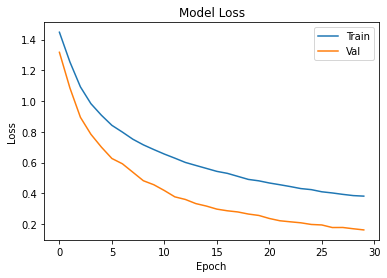

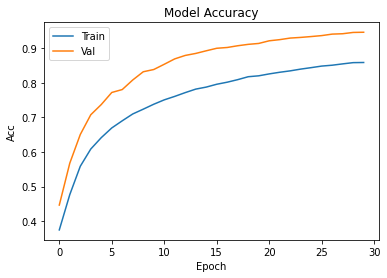

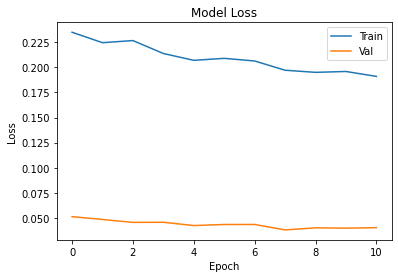

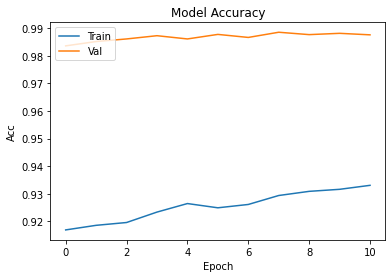

In [112]:
plot_loss(model_glove_lstm_hist)
plot_acc(model_glove_lstm_hist)
plot_loss(model_glove_lstm_hist_b)
plot_acc(model_glove_lstm_hist_b)

In [0]:
def test_model(text, model):
    print(text)
    word_list = text_to_wordlist(text)
    sequences = tokenizer.texts_to_sequences([word_list])
    sequences_input = list(itertools.chain(*sequences))
    sequences_input =  pad_sequences([sequences_input], value=0, padding="post", maxlen=windows_size).tolist()
    print(sequences_input)
    input_a = np.asarray(sequences_input)
    pred = model.predict(input_a, batch_size=None, verbose=0, steps=None)
    predicted_class = np.argmax(pred)
    print(labels[predicted_class])

In [147]:
sen = "All is going right with the party, I'm happy to know new people"
test_model(sen, model)
sen = "I want an ice cream and have some fries for lunch"
test_model(sen, model)
sen = "I'm afraid of losing my work, I don't have any money"
test_model(sen, model)
sen = "I'm worried about my future, I'm afraid of it"
test_model(sen, model)
sen = "I am a graduate student"
test_model(sen, model)
sen = "I am getting married"
test_model(sen, model)
sen = "This party is great, I know lots of people"
test_model(sen, model)
sen = "I miss my parents, brothers and sisters"
test_model(sen, model)
sen = "I detest my horrible job"
test_model(sen, model)
sen = "suicide"
test_model(sen, model)
sen = "Please kill me"
test_model(sen, model)
sen = "I am depressed"
test_model(sen, model_2lstm)
sen = "I am scared!!!"
test_model(sen, model_2lstm)

All is going right with the party, I'm happy to know new people
[[90, 99, 559, 1, 18, 128, 14, 136, 39, 0]]
moderate
I want an ice cream and have some fries for lunch
[[193, 2448, 2844, 6711, 4205, 0, 0, 0, 0, 0]]
none
I'm afraid of losing my work, I don't have any money
[[1, 18, 774, 902, 108, 211, 0, 0, 0, 0]]
moderate
I'm worried about my future, I'm afraid of it
[[1, 18, 1073, 566, 1, 18, 774, 0, 0, 0]]
moderate
I am a graduate student
[[826, 972, 0, 0, 0, 0, 0, 0, 0, 0]]
none
I am getting married
[[147, 440, 0, 0, 0, 0, 0, 0, 0, 0]]
severe
This party is great, I know lots of people
[[559, 150, 14, 51, 39, 0, 0, 0, 0, 0]]
none
I miss my parents, brothers and sisters
[[600, 3938, 294, 291, 0, 0, 0, 0, 0, 0]]
none
I detest my horrible job
[[851, 123, 0, 0, 0, 0, 0, 0, 0, 0]]
none
suicide
[[3364, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
moderate
Please kill me
[[1522, 1850, 0, 0, 0, 0, 0, 0, 0, 0]]
none
I am depressed
[[368, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
mild
I am scared!!!
[[1687, 0, 0, 0, 0, 0, 0,

In [101]:
answer_inp = Input(shape=(windows_size, ))
embedding_size_glove = 100
answer_emb1 = Embedding(vocab_size_stop+1, embedding_size_glove, weights=[embedding_matrix_lp], input_length=windows_size, trainable=False)(answer_inp)


lstm1 = LSTM(embedding_size_glove, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(answer_emb1)
lstm2 = LSTM(embedding_size_glove, dropout=0.2, recurrent_dropout=0.2)(lstm1)

X = Dropout(0.2)(lstm2)
bt = BatchNormalization()(X)
dense1 = Dense(units=256, activation="relu")(bt)

out = Dense(5,  activation='softmax')(dense1)

model_2lstm = Model(inputs=[answer_inp], outputs=[out])
model_2lstm.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model_2lstm.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 10)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 10, 100)           745000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2585

In [102]:
model_glove_2lstm_b_hist = model_2lstm.fit(train_a_b, train_y_b, validation_data=(dev_a_b, dev_y_b), epochs=30, batch_size=64, shuffle=True, callbacks=[early_stopping])

Train on 63692 samples, validate on 12754 samples
Epoch 1/30
63692/63692 [==============================] - 45s 710us/step - loss: 1.6235 - acc: 0.2376 - val_loss: 1.5746 - val_acc: 0.2780
Epoch 2/30
63692/63692 [==============================] - 43s 676us/step - loss: 1.5825 - acc: 0.2675 - val_loss: 1.5495 - val_acc: 0.2976
Epoch 3/30
63692/63692 [==============================] - 43s 681us/step - loss: 1.5502 - acc: 0.2962 - val_loss: 1.5166 - val_acc: 0.3245
Epoch 4/30
63692/63692 [==============================] - 43s 679us/step - loss: 1.4953 - acc: 0.3411 - val_loss: 1.4242 - val_acc: 0.3956
Epoch 5/30
63692/63692 [==============================] - 43s 679us/step - loss: 1.4205 - acc: 0.3914 - val_loss: 1.3177 - val_acc: 0.4559
Epoch 6/30
63692/63692 [==============================] - 44s 684us/step - loss: 1.3339 - acc: 0.4437 - val_loss: 1.2411 - val_acc: 0.5045
Epoch 7/30
63692/63692 [==============================] - 43s 680us/step - loss: 1.2605 - acc: 0.4836 - val_loss: 1.

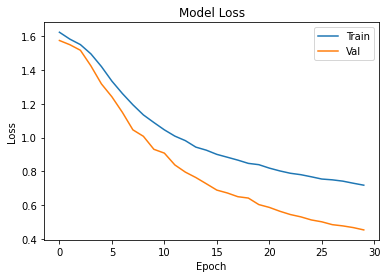

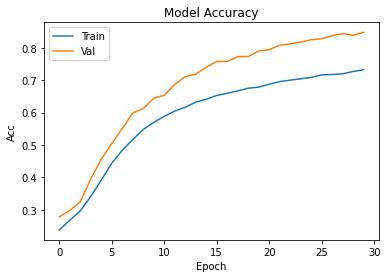

In [113]:
plot_loss(model_glove_2lstm_b_hist)
plot_acc(model_glove_2lstm_b_hist)

In [104]:
score = model_2lstm.evaluate(test_a_b, test_y_b, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.43891211531230084
Test accuracy: 0.8536484815334904


In [0]:
df_confusion = confusion_matrix(model_2lstm, test_a_b, test_y_b)

In [106]:
df_confusion


col_0,none,mild,moderate,moderately severe,severe
row_0,,,,,
none,3219,99,114,91,32
mild,174,2218,112,78,36
moderate,201,109,2725,92,73
moderately severe,199,115,111,2322,50
severe,128,97,109,110,1940


In [140]:
pip uninstall h5py

Uninstalling h5py-2.10.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/h5py-2.10.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/h5py/*
Proceed (y/n)? y
  Successfully uninstalled h5py-2.10.0


In [141]:
pip install h5py==2.7.1

     |████████████████████████████████| 5.4MB 2.7MB/s 


In [142]:
model.save('model_glove_2lstm_b.h5')
json_dict = model_glove_2lstm_b_hist.history
with open('model_glove_2lstm_b_hist.json', 'w') as f:
    f.write(str(json_dict))
print('File got created')

OSError: ignored

In [107]:
sen = "All is going right with the party, I'm happy to know new people"
test_model(sen, model_2lstm)
sen = "I want an ice cream and have some fries for lunch"
test_model(sen, model_2lstm)
sen = "I'm afraid of losing my work, I don't have any money"
test_model(sen, model_2lstm)
sen = "I'm worried about my future, I'm afraid of it"
test_model(sen, model_2lstm)
sen = "My father loves me"
test_model(sen, model_2lstm)

All is going right with the party, I'm happy to know new people
[[90, 99, 559, 1, 18, 128, 14, 136, 39, 0]]
severe
I want an ice cream and have some fries for lunch
[[193, 2448, 2844, 6711, 4205, 0, 0, 0, 0, 0]]
moderate
I'm afraid of losing my work, I don't have any money
[[1, 18, 774, 902, 108, 211, 0, 0, 0, 0]]
mild
I'm worried about my future, I'm afraid of it
[[1, 18, 1073, 566, 1, 18, 774, 0, 0, 0]]
moderate
My father loves me
[[342, 119, 0, 0, 0, 0, 0, 0, 0, 0]]
moderate


In [108]:
sen = "Please kill me"
test_model(sen, model_2lstm)

Please kill me
[[1522, 1850, 0, 0, 0, 0, 0, 0, 0, 0]]
moderate


In [143]:
sen = "I am depressed"
test_model(sen, model_2lstm)

I am depressed
[[368, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
mild


In [144]:
sen = "life is hell"
test_model(sen, model_2lstm)

life is hell
[[68, 2425, 0, 0, 0, 0, 0, 0, 0, 0]]
moderate
